In [3]:
! nvidia-smi

Wed May 25 14:29:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# Seq2seq

In [5]:
%matplotlib inline

В этом проекте мы будем учиться делать перевод с французского на английский. Примерно так:

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

Для этого мы будем исплользовать мощную идею «sequence-to-sequence» сетей (https://arxiv.org/abs/1409.3215), в которых две рекуррентные сети обучаются вместе для преоразования одной последовательности в другую.

* Encoder-сеть сжимает входную последовательность в вектор.
* Decoder-сеть разжимает этот вектор в новую последовательность.

Всё как с автоэнкодерами, только encoder и decoder из разных доменов.

Чтобы вся эта схема обучалась стабильнее, мы будем использовать механизм attention (https://arxiv.org/abs/1409.0473), позволяющий декодеру «фокусироваться» на специфичных токенах входной последовательности.

**Рекомендуемое чтение:**

-  Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation (https://arxiv.org/abs/1406.1078)
-  Sequence to Sequence Learning with Neural
   Networks (https://arxiv.org/abs/1409.3215)
-  Neural Machine Translation by Jointly Learning to Align and
   Translate 9https://arxiv.org/abs/1409.0473)
-  A Neural Conversational Model (https://arxiv.org/abs/1506.05869>)

Если кто-то пропустил предыдущие занатия, то лучше сначала сделать их: основные концепции такие же, как в языковых моделях.

In [11]:
# осторожно: тетрадка старая

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Данные

В этом проекте мы будем работать с кучей пар предложений на английском и французском.

Скачайте данные отсюда (https://download.pytorch.org/tutorial/data.zip) и возьмите оттуда файлик eng-fra.txt. В нём должно быть много строчек примерно такого формата:

    I am cold.    J'ai froid.

In [7]:
!wget https://download.pytorch.org/tutorial/data.zip

--2022-05-25 14:29:06--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.250.113, 13.224.250.5, 13.224.250.7, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.250.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2022-05-25 14:29:06 (58.2 MB/s) - ‘data.zip.1’ saved [2882130/2882130]



In [8]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Czech.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Dutch.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/English.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/French.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/German.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Greek.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Irish.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Italian.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Japanese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Korean.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Polish.txt? [y]es, [n]o, [A]ll, [N]one, [r]

In [9]:
!wc -l data/eng-fra.txt

135842 data/eng-fra.txt


In [10]:
! head data/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


Делать предобработку будем по аналогии с char-level RNN-ками из предыдущих туториалов, только на этот раз нам важно отдельно запариться с EOS (end-of-sequence) — специальным токеном, который сеть будет генерировать при окончании генерации предложения.

In [11]:
SOS_token = 0
EOS_token = 1
#BOS asdsad EOS

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def __repr__(self):
        most_popular_words = sorted(
            self.word2count.keys(), key=lambda word: self.word2count[word], reverse=True
        )[:10]
        most_popular_words = ", ".join(most_popular_words)
        return f"Language: {self.name} | Num words: {self.n_words} | Most popular: {most_popular_words}"

Все файлы в юникоде. Чтобы  облегчить нам работу, мы переведем все в ASCII, сделаем lowercase и выкинем большинство пунктуации.

In [9]:
# "hello!" -> hello, ! 

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

При чтении данных разделим файл на строки, а строки на пары.




In [13]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [14]:
!pip install transformers

n
n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

n


Данных у нас **много**, но мы сейчас хотим обучить что-нибудь по-быстрому, поэтому оставим оттуда только короткие и простые предложения — с длиной до 10 слов (включая пунктуацию).

In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Полный процесс такой:

- Считать текстовый файл, просплитить по линиям, а затем по парам.
- Нормализовать текст, профильтровать по длине.
- Сделать готовые списки слов из сырых предложений в каждом языке.

In [16]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous etes un traitre .', 'you re a traitor .']


In [17]:
input_lang

Language: fra | Num words: 4345 | Most popular: ., je, suis, est, vous, pas, de, il, nous, tu

In [18]:
output_lang

Language: eng | Num words: 2803 | Most popular: ., i, re, you, m, he, not, is, a, to

In [19]:
len(pairs)

10599

In [20]:
pairs[24]

['je vais bien .', 'i m fine .']

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.


Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.




(https://blog.floydhub.com/content/images/2019/07/image17-1.jpg)

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # num_embedding = vocab_size_fra
        self.embedder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # (batch_size, num_words) -> (batch_size, num_words, dim_1)
        embeddings = self.embedder(input).view(1, 1, -1)
        # (batch_size, num_words, dim_2)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
tokens = torch.randint(0, 1000, size=(128, 40))
embedder = nn.Embedding(1000, 128)  # здесь лежит матрица

In [23]:
onehot = torch.nn.functional.one_hot(tokens, num_classes=1000)

In [24]:
embeddingds_first_way = embedder(tokens)

In [25]:
embeddingds_first_way.size()

torch.Size([128, 40, 128])

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
_________________

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>`` or `<BOS>`
token, and the first hidden state is the context vector (the encoder's
last hidden state).
The last token is `<EOS>` whats mean end of string




In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedder = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # (batch_size, num_words, dim)
        # (1, 1, num_words * dim)
        output = self.embedder(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # (batch_size, num_words, dim) -> (batch_size, num_words, num_classes)
        # (batch_size, num_words, vocab_size_eng)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
____________

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.




In [27]:
# v^TWm
# U^T tanh (W_1 v + W_2 m)

In [28]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded[0], hidden[0]), 1)
            ), 
            dim=1
        )
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [29]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [30]:
teacher_forcing_ratio = 0.5


def train(
    input_tensor, 
    target_tensor,
    encoder, 
    decoder, 
    encoder_optimizer,
    decoder_optimizer, 
    criterion,
    max_length=MAX_LENGTH
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # y_true: [sos, i, love, pizza, eos]
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # [0.9, 0.1, 0.0]
            # [1, 0, 0]
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # beam_search is betters
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                # y_true: [sos, i, eos]
                # [sos, i, eos, love]
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [31]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [32]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [33]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [34]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [35]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [39]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=50)

0m 4s (- 121m 28s) (50 0%) 5.5426
0m 5s (- 68m 40s) (100 0%) 3.8888
0m 6s (- 50m 50s) (150 0%) 3.6900
0m 6s (- 42m 3s) (200 0%) 3.5444
0m 7s (- 36m 42s) (250 0%) 3.4793
0m 7s (- 33m 10s) (300 0%) 3.3258
0m 8s (- 30m 43s) (350 0%) 3.3972
0m 9s (- 28m 47s) (400 0%) 3.2759
0m 9s (- 27m 23s) (450 0%) 3.4339
0m 10s (- 26m 10s) (500 0%) 3.3090
0m 11s (- 25m 16s) (550 0%) 3.5082
0m 11s (- 24m 28s) (600 0%) 3.2944
0m 12s (- 23m 51s) (650 0%) 3.3569
0m 13s (- 23m 15s) (700 0%) 3.2981
0m 13s (- 22m 47s) (750 1%) 3.2673
0m 14s (- 22m 21s) (800 1%) 3.3181
0m 15s (- 22m 3s) (850 1%) 3.3468
0m 15s (- 21m 40s) (900 1%) 3.0888
0m 16s (- 21m 24s) (950 1%) 3.0178
0m 17s (- 21m 10s) (1000 1%) 3.3171
0m 17s (- 20m 59s) (1050 1%) 3.2036
0m 18s (- 20m 46s) (1100 1%) 3.1145
0m 19s (- 20m 32s) (1150 1%) 3.1502
0m 19s (- 20m 22s) (1200 1%) 3.0098
0m 20s (- 20m 12s) (1250 1%) 2.9029
0m 21s (- 20m 6s) (1300 1%) 3.2678
0m 22s (- 20m 0s) (1350 1%) 3.0468
0m 22s (- 19m 52s) (1400 1%) 2.9728
0m 23s (- 19m 46s) (1450

In [40]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes nerveusement usee .
= you re a nervous wreck .
< you re a nervous . <EOS>

> je ne suis certainement pas votre amie .
= i m certainly not your friend .
< i m certainly not your friend . <EOS>

> nous prenons l ascendant .
= we re taking over .
< we re taking over . <EOS>

> tu es invite .
= you re invited .
< you re invited . <EOS>

> vous n etes qu un lache .
= you re nothing but a coward .
< you re just a coward . <EOS>

> vous n etes pas ma mere .
= you re not my mother .
< you aren t my mother . <EOS>

> elles sont mignonnes .
= they re cute .
< they re exhausted . <EOS>

> c est un homme de faible volonte .
= he s a weak willed man .
< he is a man of a . . <EOS>

> j en ai marre de tes plaintes .
= i m getting tired of your complaints .
< i m tired of your complaints . <EOS>

> je suis quelque peu decu .
= i m a little disappointed .
< i m a little disappointed . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [31]:
%matplotlib inline

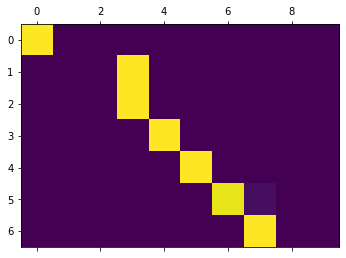

In [42]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je ai pas trop froid .")
plt.matshow(attentions.numpy())
plt.show()

Remember the motivation for attention? At different steps, the decoder may need to focus different source tokens, the ones which are more relevant at this step. Let's look at attention weights - which source words does the decoder use?


input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


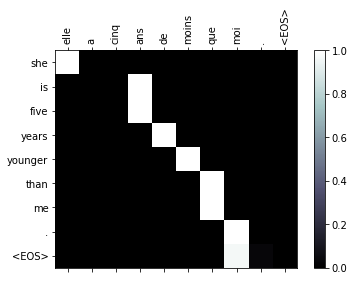

input = elle est trop petit .
output = she is too loud . <EOS>


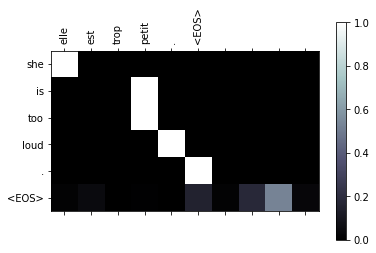

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


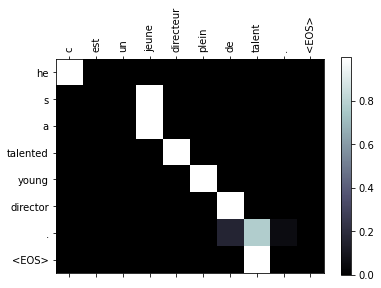

In [43]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")



evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = dans vos bras !
output = you re kidding ! <EOS>


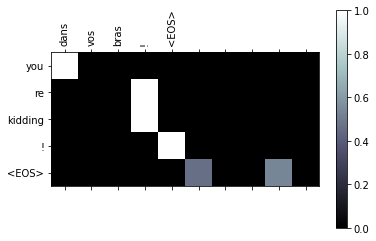

In [44]:
evaluateAndShowAttention("dans vos bras !")

In [46]:
"From the examples, we see that attention learned (soft) alignment between source and target words - the decoder looks at those source tokens which it is translating at the current step."

'From the examples, we see that attention learned (soft) alignment between source and target words - the decoder looks at those source tokens which it is translating at the current step.'

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




Dataset source: https://www.kaggle.com/datasets/kaushal2896/english-to-german

In [45]:
!unzip deu.txt.zip

Archive:  deu.txt.zip
  inflating: deu.txt                 


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('deu.txt', names=['en', 'de'], sep='\t', usecols=[0, 1])

In [3]:
df.sample(10)

,en,de
45653,Why are you home now?,Warum bist du jetzt zu Hause?
213555,"No matter what you do, you're not going to get...","Was auch immer du tust, du wirst mich nicht zu..."
132180,Tom was blinded by the sunlight.,Das Sonnenlicht blendete Tom.
61991,Did you go to the beach?,Bist du an den Strand gegangen?
132734,What're Tom and Mary doing here?,Was machen Tom und Maria hier?
186937,This carpet is more valuable than that one.,Dieser Teppich ist kostbarer als jener.
219519,There is an urgent need for a more effective m...,"Eine effektivere Methode, diese Krankheit zu b..."
173207,An innocent man was arrested by mistake.,Ein Unschuldiger wurde irrtümlich festgenommen.
42993,Someone gave me this.,Jemand hat mir das hier gegeben.
95401,Don't use all the hot water.,Nimm nicht das ganze heiße Wasser!


In [4]:
df.shape

(221533, 2)

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def __repr__(self):
        most_popular_words = sorted(
            self.word2count.keys(), key=lambda word: self.word2count[word], reverse=True
        )[:10]
        most_popular_words = ", ".join(most_popular_words)
        return f"Language: {self.name} | Num words: {self.n_words} | Most popular: {most_popular_words}"

In [6]:
def read_langs(df, lang1, lang2, reverse=False):
    pairs = df.applymap(normalizeString).values.tolist()
    
    if reverse:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

def filter_Pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filter_Pairs(pairs):
    return [pair for pair in pairs if filter_Pair(pair)]

In [12]:
def prepareData(df, lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(df, lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_Pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(df, 'en', 'de', False)
print(random.choice(pairs))

Read 221533 sentence pairs
Trimmed to 169250 sentence pairs
Counting words...
Counted words:
en 13206
de 26411
['did you phone me ?', 'hast du mich angerufen ?']


In [13]:
input_lang

Language: en | Num words: 13206 | Most popular: ., tom, i, you, ?, the, to, a, is, t

In [14]:
output_lang

Language: de | Num words: 26411 | Most popular: ., tom, ich, ?, ist, nicht, das, sie, du, es

Пытался скачать pretrained, но ни один способ не сработал :(

In [15]:
import gensim

#model = gensim.downloader.load("glove-twitter-25")
#model = gensim.models.Word2Vec.load()
# через load_version тоже не работает

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # num_embedding = vocab_size_fra
        self.embedder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # (batch_size, num_words) -> (batch_size, num_words, dim_1)
        embeddings = self.embedder(input).view(1, 1, -1)
        # (batch_size, num_words, dim_2)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedder = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # (batch_size, num_words, dim)
        # (1, 1, num_words * dim)
        output = self.embedder(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # (batch_size, num_words, dim) -> (batch_size, num_words, num_classes)
        # (batch_size, num_words, vocab_size_eng)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded[0], hidden[0]), 1)
            ), 
            dim=1
        )
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
teacher_forcing_ratio = 0.5


def train(
    input_tensor, 
    target_tensor,
    encoder, 
    decoder, 
    encoder_optimizer,
    decoder_optimizer, 
    criterion,
    max_length=MAX_LENGTH
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # y_true: [sos, i, love, pizza, eos]
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # [0.9, 0.1, 0.0]
            # [1, 0, 0]
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # beam_search is betters
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                # y_true: [sos, i, eos]
                # [sos, i, eos, love]
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=50)

0m 4s (- 124m 40s) (50 0%) 5.8697
0m 5s (- 71m 46s) (100 0%) 5.3414
0m 6s (- 55m 2s) (150 0%) 5.9143
0m 7s (- 46m 27s) (200 0%) 5.6272
0m 8s (- 41m 36s) (250 0%) 5.7328
0m 9s (- 38m 17s) (300 0%) 5.6041
0m 10s (- 36m 0s) (350 0%) 5.6294
0m 11s (- 34m 12s) (400 0%) 5.5043
0m 11s (- 32m 59s) (450 0%) 5.5788
0m 12s (- 31m 59s) (500 0%) 5.3399
0m 13s (- 31m 0s) (550 0%) 5.5204
0m 14s (- 30m 16s) (600 0%) 5.4441
0m 15s (- 29m 38s) (650 0%) 5.3058
0m 16s (- 29m 6s) (700 0%) 5.1365
0m 17s (- 28m 42s) (750 1%) 5.4241
0m 18s (- 28m 15s) (800 1%) 5.3608
0m 19s (- 27m 53s) (850 1%) 5.2121
0m 20s (- 27m 36s) (900 1%) 4.9348
0m 21s (- 27m 23s) (950 1%) 5.4805
0m 21s (- 27m 6s) (1000 1%) 5.1639
0m 22s (- 26m 53s) (1050 1%) 5.0807
0m 23s (- 26m 39s) (1100 1%) 5.0234
0m 24s (- 26m 28s) (1150 1%) 5.1840
0m 25s (- 26m 19s) (1200 1%) 5.1915
0m 26s (- 26m 9s) (1250 1%) 4.9734
0m 27s (- 25m 59s) (1300 1%) 5.0110
0m 28s (- 25m 50s) (1350 1%) 4.9567
0m 29s (- 25m 43s) (1400 1%) 4.9168
0m 30s (- 25m 35s) (145

In [28]:
evaluateRandomly(encoder1, attn_decoder1)

> i fear nothing .
= ich furchte nichts .
< ich habe nichts . <EOS>

> this is your fault .
= das ist deine schuld .
< das ist eure . . <EOS>

> we spent the night in a cheap hotel .
= wir ubernachteten in einem billigen hotel .
< wir haben in der einem in der . <EOS>

> make yourselves useful .
= macht euch nutzlich !
< mach es sich fehler . <EOS>

> tom gave his dog water .
= tom gab seinem hund wasser .
< tom gab sich hund hund hund . <EOS>

> does tom know how to do this ?
= wei tom wie man das macht ?
< wei tom das das ? <EOS>

> we ll meet again .
= wir werden uns wiedersehen .
< wir werden uns wieder . <EOS>

> i belong to the sailing club .
= ich gehore zum segelklub .
< ich habe den die . . <EOS>

> that s tom s family .
= das ist toms familie .
< das ist toms familie . <EOS>

> do you know when he will come ?
= wei t du wann er kommen wird ?
< wei du wann wenn er kommt ? <EOS>



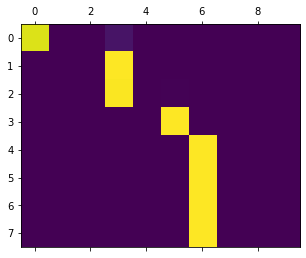

In [33]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "do you know when he will come ?")
plt.matshow(attentions.numpy())
plt.show()

input = i fear nothing .
output = ich habe nichts . <EOS>


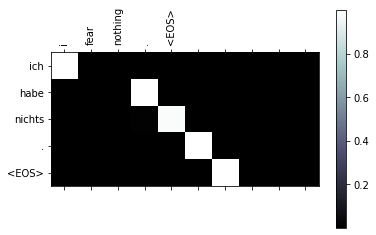

input = this is your fault .
output = das ist eure . <EOS>


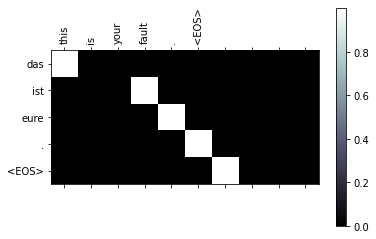

input = make yourselves useful .
output = gib es sich fehler . <EOS>


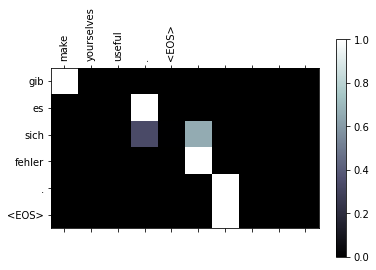

In [34]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i fear nothing .")

evaluateAndShowAttention("this is your fault .")



evaluateAndShowAttention("make yourselves useful .")